In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rflearn.env import BlackJack, GridWorld, CliffGridWorld, WindGridWorld
from rflearn.algo import MCIteration, TabularPolicy, TabularQValue

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cliff Gridworld

In [42]:
cgrid = CliffGridWorld(4, 12)
qvalue = TabularQValue(cgrid.S, cgrid.A)
policy = TabularPolicy(cgrid.S, cgrid.A, epsilon=0.1)

mc_model = MCIteration(cgrid, qvalue, policy)
mc_model.fit(gamma=1, alpha=0.01)

<AxesSubplot:>

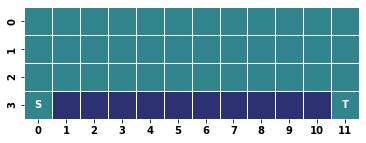

In [43]:
cgrid.plot_grid('st')

In [44]:
mc_model.transform(1500, kbatch=40)

100%|██████████| 1500/1500 [01:58<00:00, 12.70it/s]


In [45]:
v_vals = qvalue.get_all_values(policy)
np.round(v_vals.reshape(cgrid.shape)/100)

array([[-0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -1., -1., -1., -0., -1., -0., -0., -0., -0.],
       [-0., -2., -2., -4., -4., -5., -4., -4., -3., -3., -2.,  0.]])

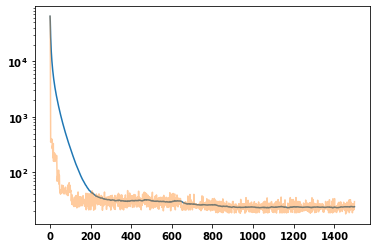

In [46]:
(-1*pd.Series(mc_model.hist['avg_r'])).ewm(halflife=25).mean().plot(logy=True)
(-1*pd.Series(mc_model.hist['avg_r'])).plot(alpha=0.4, logy=True)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

# Gridworld MC

In [19]:
# _grid = [
#     [0, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 0],
#     [0, 0, 0, 0, 0, 0, 0],
# ]
# grid = GridWorld(grid=_grid, terminals=[0])
grid = GridWorld(4,4)
qvalue = TabularQValue(grid.S, grid.A)
policy = TabularPolicy(grid.S, grid.A, epsilon=0.05)

mc_model = MCIteration(grid, qvalue, policy)
mc_model.fit(gamma=1)

In [20]:
mc_model.transform(iter=500, kbatch=30)

100%|██████████| 500/500 [00:01<00:00, 264.83it/s]


In [21]:
v_vals = qvalue.get_all_values(policy)
np.round(v_vals.reshape(grid.shape))

array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

In [143]:
def trace_avg_rewards(hist):
    trace = []
    for batch in hist:
        avg_r = 0
        for ep in batch:
            avg_r += ep.get_total_rewards()
        trace.append(avg_r / len(batch))
    return pd.Series(trace)

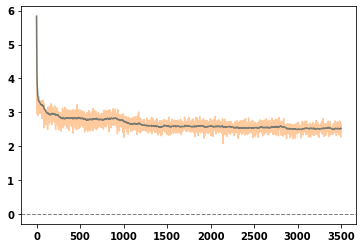

In [144]:
trace = np.log(-1 * trace_avg_rewards(mc_model.hist))
trace.ewm(halflife=25).mean().plot()
trace.plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

In [145]:
pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]

,up,down,left,right
0,0,0,0,0
1,139,151,3288,134
2,78,64,2728,71
3,102,2625,317,78
4,104,1985,971,104
5,94,2002,1128,86
6,59,491,1979,52
7,3500,1015,1002,973
8,860,924,3500,856
9,886,784,3500,812


# Blackjack MC

In [82]:
def fix_policy(env, eps=0.1, threshold=20):
    policy = []
    for state in env:
        if state[1] >= threshold:
            policy.append([0, 1])
        else:
            policy.append([1, 0])
    policy = TabularPolicy(
        env.S, env.A, epsilon=eps,
        policy=np.array(policy).astype('float')
    )
    return policy

In [66]:
game = BlackJack()
qvalue = TabularQValue(game.S, game.A)
policy = TabularPolicy(game.S, game.A, epsilon=0.1)

mc_model = MCIteration(game, qvalue, policy)
mc_model.fit(gamma=1)

In [67]:
mc_model.transform(15000, kbatch=20)

100%|██████████| 15000/15000 [00:45<00:00, 332.39it/s]


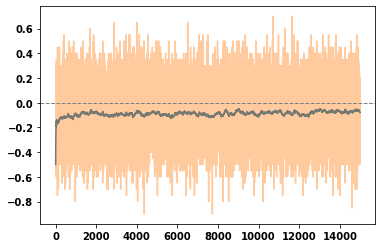

In [68]:
pd.Series(mc_model.hist['avg_r']).ewm(halflife=100).mean().plot()
pd.Series(mc_model.hist['avg_r']).plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

In [69]:
idx = pd.MultiIndex.from_tuples([s for s in game])
v_vals = pd.Series(qvalue.get_all_values(policy), index=idx)

cnts = pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]
cnts.index = idx

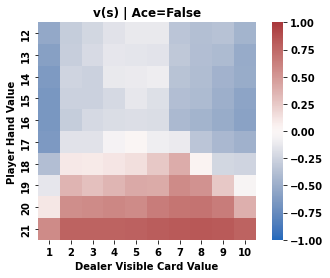

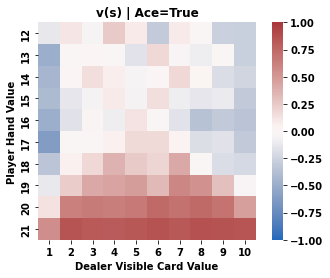

In [70]:
import seaborn as sns

d = v_vals.unstack().T
for flag in [False, True]:
    ax = sns.heatmap(d[flag].T, vmin=-1, vmax=1, center=0, square=True, cmap="vlag")
    plt.title(f'v(s) | Ace={flag}')
    plt.xlabel('Dealer Visible Card Value')
    plt.ylabel('Player Hand Value')
    plt.show()

In [71]:
cnts.unstack().T

False                                                               \
             12    13     14     15     16     17     18     19     20    21   
hit   1    4708  4752   4030   5080   4438    544    280    314    278   140   
      2    4134   260    256   1002    250    282    184    198    270    86   
      3     278   202    276    284    248    412    200    186    274    40   
      4    2112   304    230   1618    214    208    180    164    274    66   
      5     348   254    218    190    420    202    226    168    266    68   
      6     266   274    262    250    202    204    200    172    238    52   
      7    1324  2922   4562   4600   4568    278    224    244    374   122   
      8    4450  4708   4806   4892   5024    304    260    258    342   182   
      9    4542  4824   3560   4690    990    266    260    236    326   128   
      10  15140  6956  14780  15698   1074   1024   1016    934   1144   510   
stand 1     282   474   1020    312    834   4796   5002   4774   6296  2742   
      2     230  4688   4368   3788   4044   3914   3774   3496   5012  1342   
      3    4542  4080   4234   4082   3968   3430   3170   3158   4814   982   
      4    2716  4630   3780   2912   4072   3796   3664   3202   4958  1246   
      5    4612  4376   4110   3592   3708   3508   3478   3264   4778  1066   
      6    4642  4612   4200   4146   3402   3696   3374   3196   4770  1012   
      7    3436  1986    256    214    336   4644   4466   4204   5940  2150   
      8     360   316    270    324    328   4956   4564   4762   6272  2650   
      9     322   334   1580    486   4130   4854   4508   3898   5800  2244   
      10   1074  9892   1496   1168  15660  15262  14466  13626  16324  8050   

         True                                                        
           12    13    14    15    16    17    18    19    20    21  
hit   1    98   372   426   498   476    72    88    24    36   168  
      2   216   374   580   664    50   220   732   428    74   142  
      3   180   506   412   630   686   572    32    46    50   138  
      4   156   570   474   300   288    24    48    62    78   120  
      5   210    32    78    42   462   536   670    32    40   110  
      6    22   412   552   538   686    48   830   302    76   162  
      7   208   542   602   638   510   780   146    58    58   160  
      8   200   366   538   630   112   180   760    42    70   120  
      9   184   538   540   654   724   798    44    38    50   156  
      10  770  2098  2300  2476  2688  2924  3386   326   220   536  
stand 1    14    28    26    26    78   522   580   642   710  1756  
      2     8    50    22    30   682   546    32   432   814  2348  
      3    12    96    24    30    36   204   866   892   854  2406  
      4    64    34   152   208   468   734   770   766   780  2338  
      5    22   532   472   590    28   196    38   804   834  2444  
      6   188   154    32   108    32   664    52   596   918  2442  
      7    16    42    24    60   194    42   612   938   918  2518  
      8    18   190    58    42   688   574    52   752   850  2462  
      9    20    74    72    36    44    68   898   854   800  2470  
      10  148   164   126   156   194   174   208  3534  3842  8462